** Differential gene expression analysis** 
data GSE172114:  46 critical , 23 non-critical COVID19 samples

In [ ]:
#Dependencies
library(GEOquery)
library(edgeR)
library(edgeR)
library(ggplot2)
library(ggfortify)
library(pheatmap)

In [1]:
#data peprocessing
data <- read.csv(file = "path/GSE172114_rsem_gene_count_matrix_TMM_69samples.csv") # data availble at GEO GSE172114
dim(data)
# Get metadata
gse <- getGEO("GSE172114", GSEMatrix = TRUE)
metadata <- pData(phenoData(gse[[1]]))
# Inspect metadata - these commands provide output for your manual inspection, so they're left as is
#dim(metadata)
#colnames(metadata)
#metadata[,40:42]
#sum(metadata[,41]=="Critical") # 46
#sum(metadata[,41]=="Non-critical") # 23 first
metadata[20,c('data_processing','data_processing.1','data_processing.2','data_processing.3','data_processing.4')]
head(data)

linear_data <- 2^data[,-1]
rownames(linear_data)<-data[,1]
ldata<-cbind(data[,1],linear_data)
#any(linear_data<0)


[1] 15957    70

Found 1 file(s)

GSE172114_series_matrix.txt.gz



,data_processing,data_processing.1,data_processing.2,data_processing.3,data_processing.4
,<chr>,<chr>,<chr>,<chr>,<chr>
GSM5242147,"Raw sequencing data was trimmed with Skewer v0.2.1 and alignment was performed with STAR v2.5.3a, using SAMtools v0.1.19 for sorting/indexing",Quantification of gene expression was performed using RSEM (v1.3.0) with GENCODE annotation v25,TMM normalization with edgeR,Genome_build: GRCh38,"Supplementary_files_format_and_content: log2 normalized TMM counts, with samples as columns and genes as rows"


,X,C10,C11,C12,C13,C14,C15,C16,C17,C18,⋯,P43,P44,P46,P47,P4,P5,P6,P7,P8,P9
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000419.12_DPM1,3.463,3.099,4.694,4.171,4.199,2.674,4.098,4.230,2.418,⋯,3.669,4.071,4.543,3.728,3.677,3.926,4.453,3.257,4.378,4.260
2,ENSG00000000457.13_SCYL3,5.275,5.462,5.485,5.167,5.789,4.978,4.879,5.524,4.839,⋯,5.583,5.372,5.634,5.924,4.370,5.478,4.768,5.308,5.591,5.635
3,ENSG00000000460.16_C1orf112,3.477,3.344,3.405,3.214,3.704,3.639,3.582,3.133,3.384,⋯,3.699,3.485,3.416,3.276,3.060,3.120,3.833,3.538,3.485,2.456
4,ENSG00000000938.12_FGR,7.918,8.011,7.458,7.567,8.860,8.053,7.395,9.031,8.466,⋯,8.730,8.082,9.232,8.628,7.624,9.557,9.083,8.535,8.670,9.678
5,ENSG00000000971.15_CFH,2.384,2.596,3.883,2.425,1.927,1.075,1.569,2.430,2.032,⋯,2.506,2.319,0.555,1.460,3.333,1.366,1.771,2.221,3.639,2.300
6,ENSG00000001036.13_FUCA2,3.526,3.883,4.141,4.034,3.800,3.922,4.331,4.481,4.229,⋯,3.882,4.541,4.257,3.499,3.472,4.336,4.595,3.921,4.321,4.605


** DE Analysis**

this data was tmm normalised. edgeR use tmm normalisation for DE analysis and i only remove this step from analysis with edgeR to prevent redundancy. but this data cant be used for DEseq2 because its not raw count.

In [ ]:
#EdgeR DE analysis

#  DGE object
y <- DGEList(counts=linear_data)
# Filtering out genes with low counts
keep <- rowSums(cpm(y) > 1) >= 2
y <- y[keep, , keep.lib.sizes=FALSE]
#  design matrix
group <- factor(c(rep("Non-critical",23), rep("Critical",46)))
design <- model.matrix(~group)
# dispersions
y <- estimateDisp(y, design)
# exact test for differential expression
fit <- glmQLFit(y, design)
qlf <- glmQLFTest(fit, coef=2)
results <- topTags(qlf)
all_results <- topTags(qlf, n=Inf)  # Setting n=Inf for having all results
sig_results <- all_results[all_results$table$FDR < 0.05, ]
#  cutoffs
results_df <- sig_results@.Data[[1]]
filtered_DEGs <- results_df[results_df$FDR < 0.05 & abs(results_df$logFC) > 1, ]


In [5]:
# Calculate the number of upregulated and downregulated genes
upregulated_genes <- nrow(filtered_DEGs[filtered_DEGs$logFC >= 1, ])
downregulated_genes <- nrow(filtered_DEGs[filtered_DEGs$logFC <= -1, ])
print(paste("Number of significantly upregulated genes:", upregulated_genes))
print(paste("Number of significantly downregulated genes:", downregulated_genes))

[1] "Number of significantly upregulated genes: 448"
[1] "Number of significantly downregulated genes: 333"


In [36]:
head(all_results)
#write.csv(all_results, "EdgeR all result", row.names = TRUE)

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000119714.10_GPR68,1.6107857,2.503416,106.25953,7.886445e-16,1.258440e-11
ENSG00000134545.13_KLRC1,1.7860245,2.786699,88.62662,3.492714e-14,2.480526e-10
ENSG00000007264.14_MATK,1.5619836,4.046020,87.35693,4.663519e-14,2.480526e-10
ENSG00000273047.1_RP4-583P15.14,1.1644053,2.820845,83.10987,1.247982e-13,4.691434e-10
ENSG00000099622.13_CIRBP,0.7252374,6.888404,82.41462,1.470024e-13,4.691434e-10
ENSG00000149823.7_VPS51,0.9524669,6.297903,79.31469,3.079226e-13,7.579722e-10


**Visualisation**

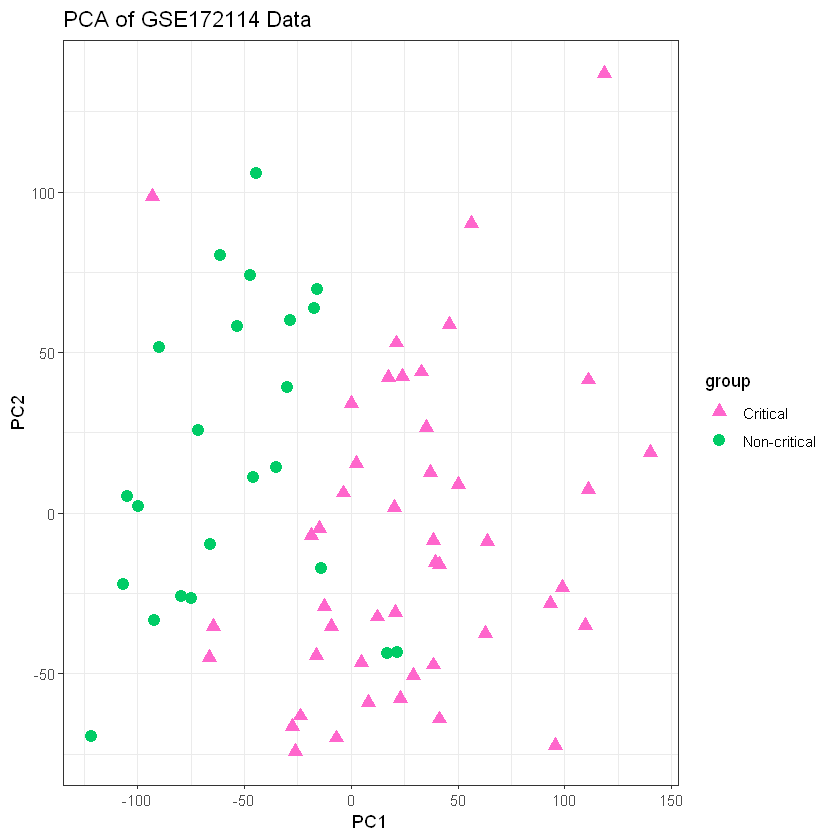

In [ ]:

# excluding gene names
expr_data <- data[, -1]
rownames(expr_data) <- data[, 1]

# Perform PCA on the transposed expression data
pca_result <- prcomp(t(expr_data), scale. = TRUE)
pc_df <- as.data.frame(pca_result$x)
pc_df$group <- c(rep("Non-critical", 23), rep("Critical", 46))

#  PCA results , coloring by group
pca_plot <- ggplot(pc_df, aes(x = PC1, y = PC2, color = group)) +
  geom_point(aes(shape = group), size = 3) +
  theme_bw() +
  labs(title = "PCA of GSE172114 Data") +
  scale_color_manual(values = c("Critical" = "#FF66CC", "Non-critical" = "#00CC66")) +
  scale_shape_manual(values = c("Critical" = 17, "Non-critical" = 19))

print(pca_plot)
ggsave("pca_plot.png", pca_plot, width = 8, height = 6, dpi = 300)


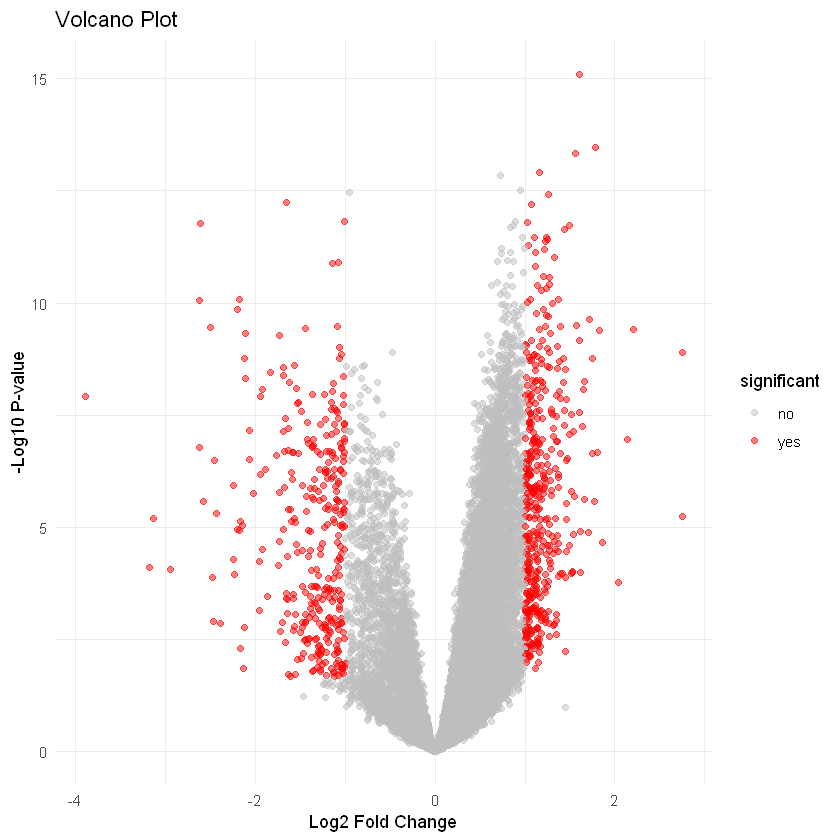

In [40]:

# dataframe for plotting
volcano_data <- data.frame(
  logFC = all_results$table$logFC,
  minusLog10P = -log10(all_results$table$PValue))

# Adding a significance column based on FDR and logFC
volcano_data$significant <- ifelse(all_results$table$FDR < 0.05 & abs(all_results$table$logFC) > 1, "yes", "no")

volcano_plot <- ggplot(volcano_data, aes(x = logFC, y = minusLog10P, color = significant)) +
  geom_point(alpha = 0.5) +
  labs(title = "Volcano Plot",
       x = "Log2 Fold Change",
       y = "-Log10 P-value") +
  scale_color_manual(values = c("no" = "grey", "yes" = "red")) +  # change color as per preference
  theme_minimal()

print(volcano_plot)
ggsave("volcano_plot.png", volcano_plot, width = 8, height = 6, dpi = 300)


In [ ]:
#Heatmap

#  Heatmap for all data:
all_data_transposed <- t(data[,-1])
annotation <- data.frame(Group = c(rep("Non-critical", 23), rep("Critical", 46)))
rownames(annotation) <- colnames(linear_data)
pheatmap(all_data_transposed, annotation_row = annotation, show_rownames = FALSE, 
         main = "All Data", clustering_distance_rows = "euclidean", 
         clustering_method = "complete")
# Heatmap for differentially expressed genes:
DEGs_data <- data[rownames(filtered_DEGs),-1 ]
DEGs_data_transposed <- t(DEGs_data)
pheatmap(DEGs_data_transposed, annotation_row = annotation, show_rownames = FALSE,
         main = "Differentially Expressed Genes", clustering_distance_rows = "euclidean",
         clustering_method = "complete")